In [55]:
import pandas as pd
import numpy as np
import requests
import datetime
import math
import time

import matplotlib.pyplot as plt
% matplotlib inline
% config InlineBackend.figure_format = 'retina'

import seaborn as sns

In [9]:
bdata = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20150101&end="+time.strftime("%Y%m%d"))[0]
bdata = bdata.assign(Date=pd.to_datetime(bdata['Date']))
bdata['Volume'] = bdata['Volume'].astype('int64')
bdata = bdata.sort_values(by='Date')
bdata = bdata.reset_index(drop=True)
bdata.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2015-01-01,320.44,320.44,314.00,314.25,8036550,4380820000
1,2015-01-02,314.08,315.84,313.56,315.03,7860650,4295210000
2,2015-01-03,314.85,315.15,281.08,281.08,33054400,4307010000
3,2015-01-04,281.15,287.23,257.61,264.19,55629100,3847150000
4,2015-01-05,265.08,278.34,265.08,274.47,43962800,3628490000


Closing Price from 1/1/2015 until date of query, 5/6/2018

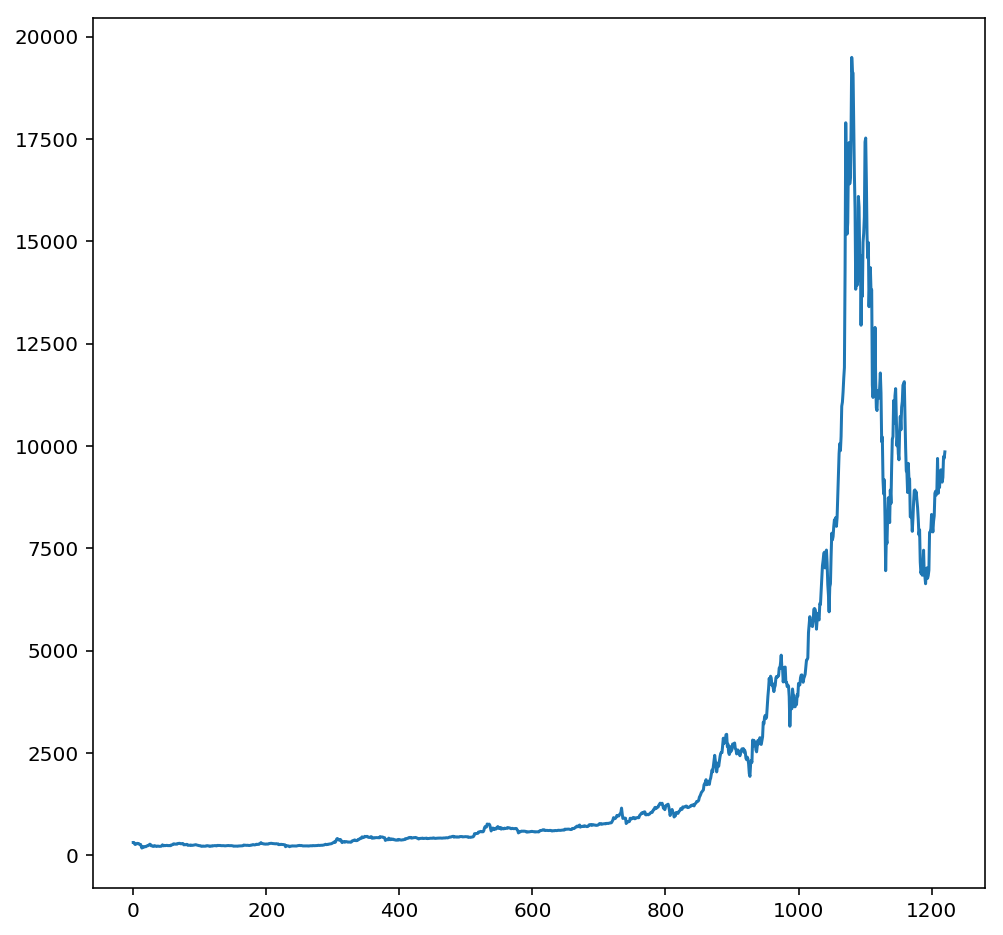

In [27]:
bdata['Close'].plot(figsize=(8,8))

Calculated difference from current to previous day

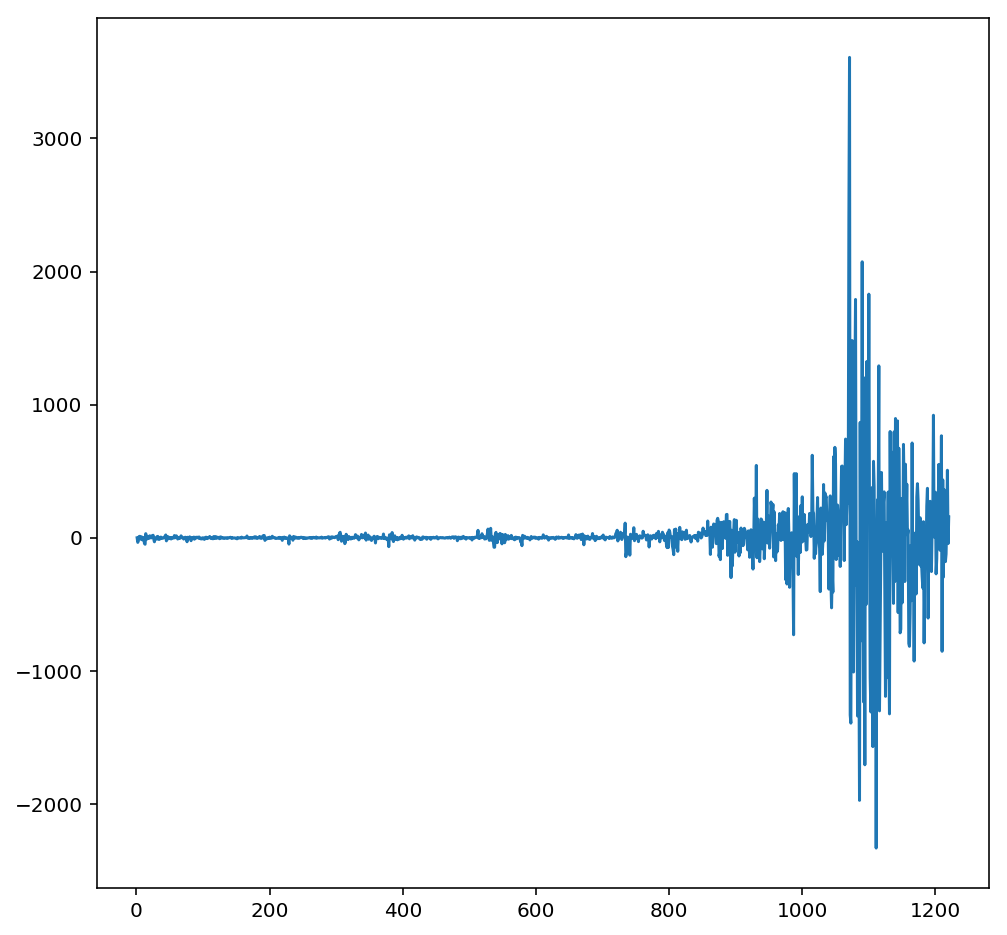

In [28]:
bdata['First Difference'] = bdata['Close'] - bdata['Close'].shift()
bdata['First Difference'].plot(figsize=(8,8))

Natural log transformation of original graph exposes proportional differences

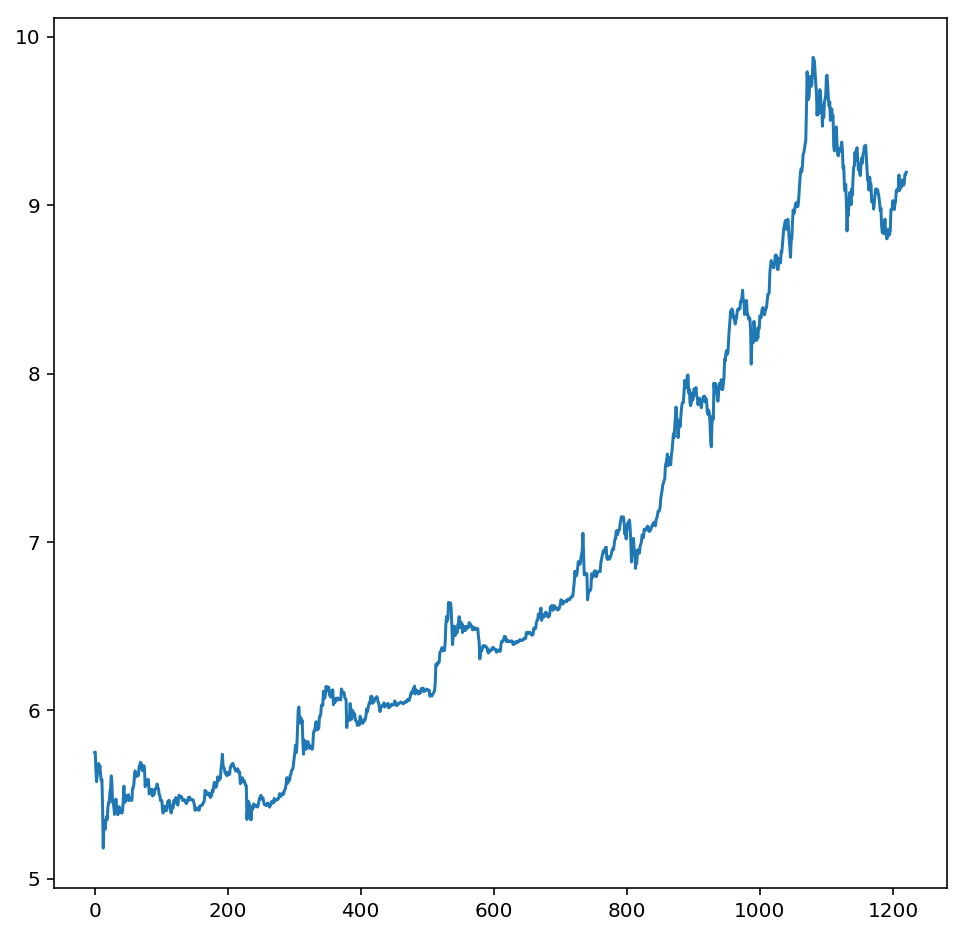

In [29]:
bdata['Natural Log'] = bdata['Close'].apply(lambda x: np.log(x))
bdata['Natural Log'].plot(figsize=(8,8))

The original variance makes it extremely hard to see any changes in comparison, since the spike in prices makes it hard to compare other values

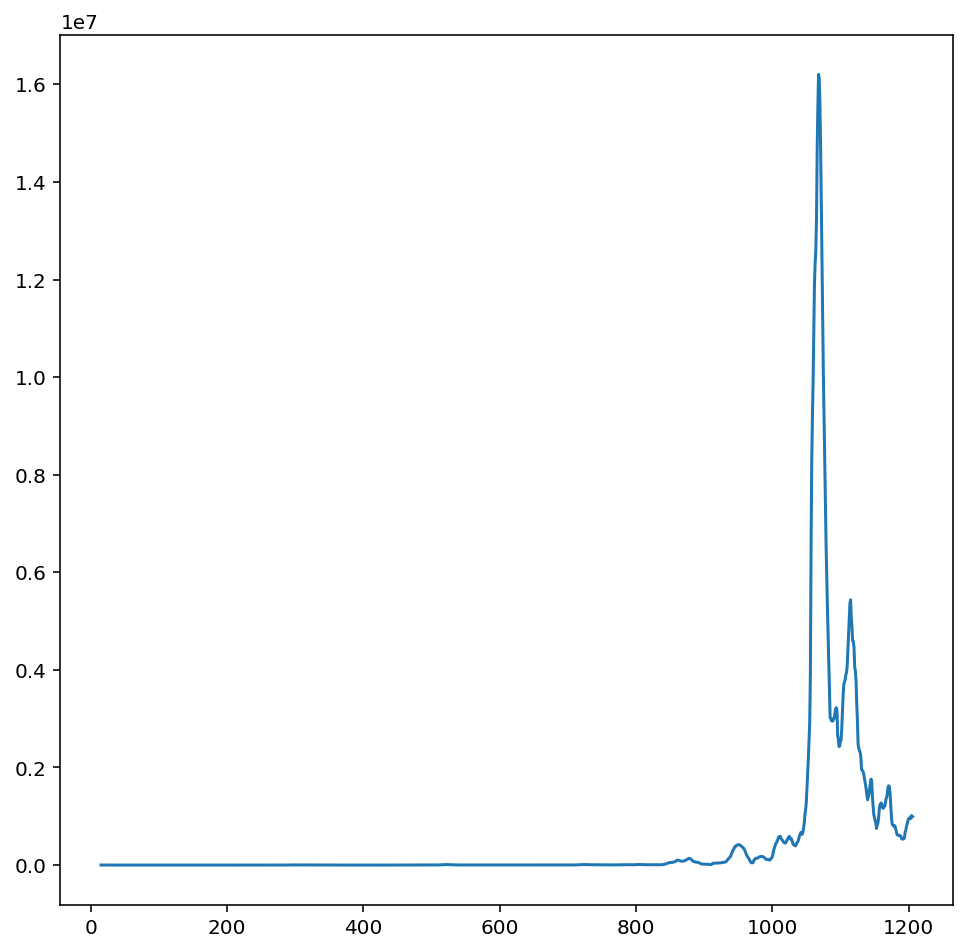

In [30]:
bdata['Original Variance'] = bdata['Close'].rolling(window=30, center=True).var()
bdata['Original Variance'].plot(figsize=(8,8))

Using a log variance, we can see all changes exposed.
However, we are now in a period where Bitcoin has been exposed to a larger population.  Do old trends still apply to the current market? I hope to test this with models that use different cutoff dates for the data.

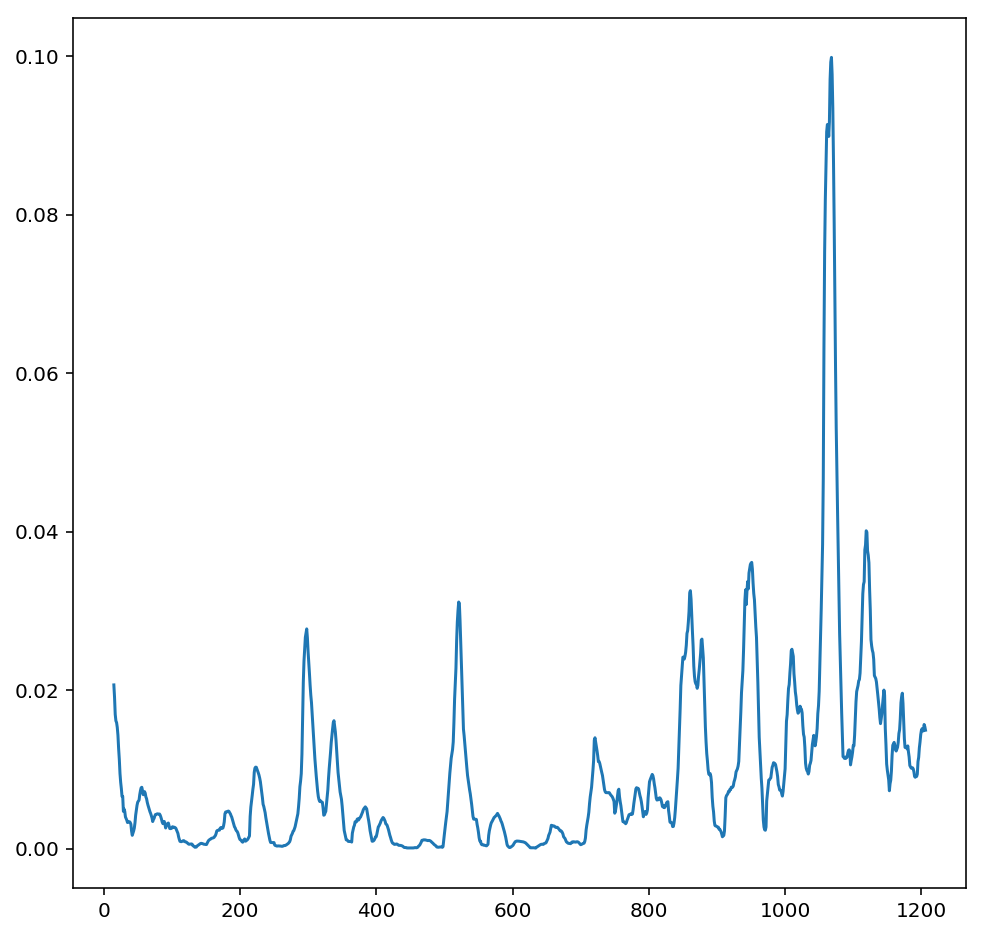

In [31]:
bdata['Log Variance'] =  bdata['Natural Log'].rolling(window=30, center=True).var()
bdata['Log Variance'].plot(figsize=(8,8))

Getting the logged first difference makes the data stationary ( a requirement for good time series analysis), and makes the changes in price much easier to see

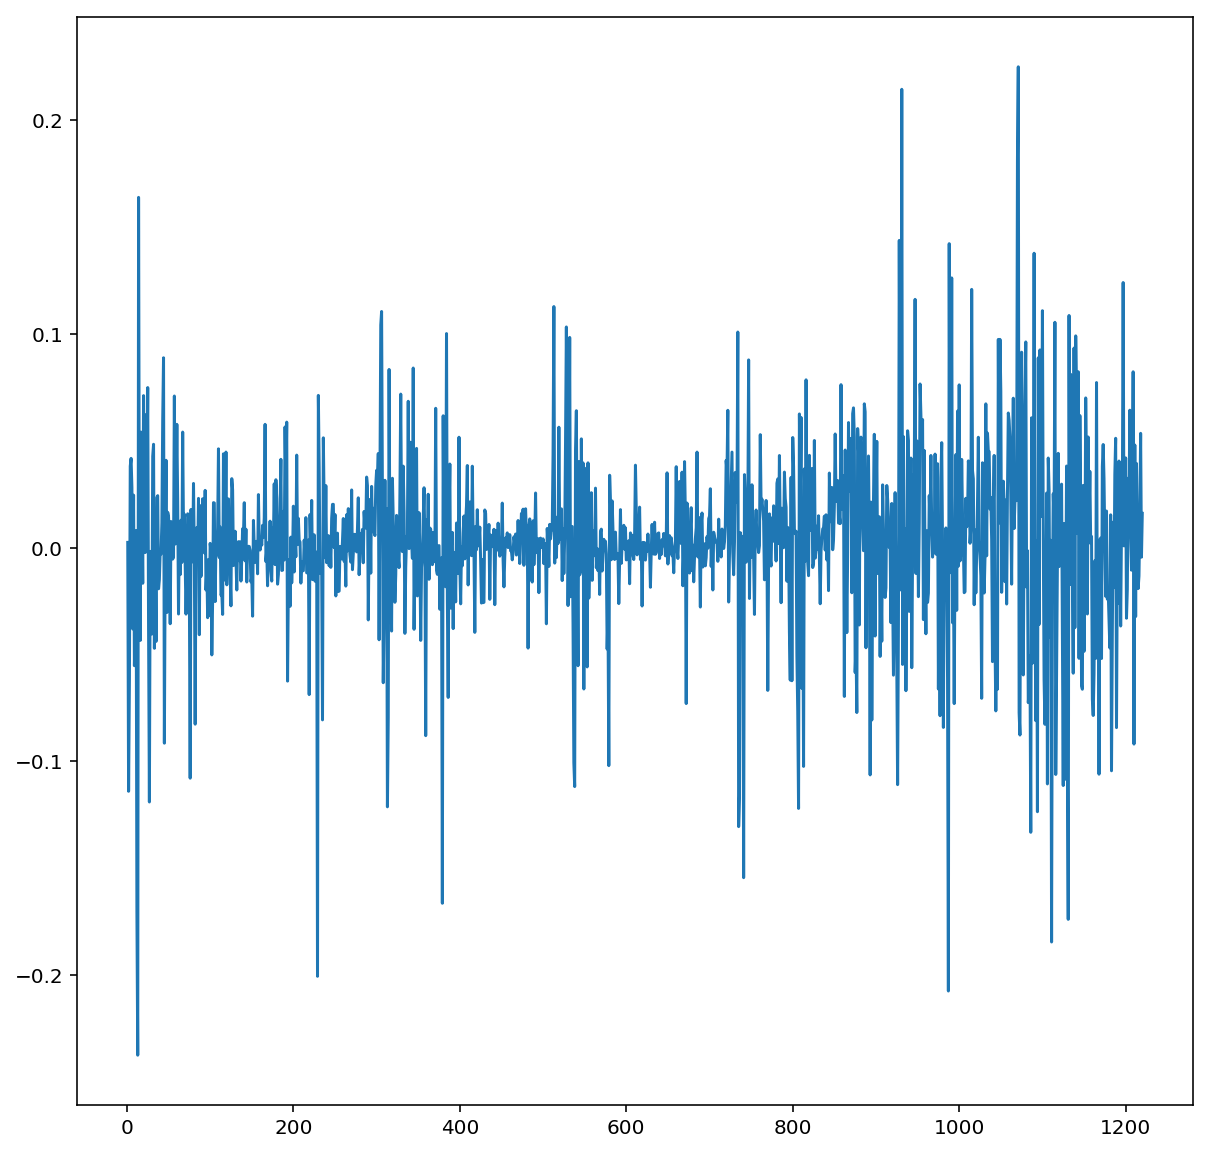

In [16]:
bdata['Logged First Difference'] = bdata['Natural Log'] - bdata['Natural Log'].shift()
bdata['Logged First Difference'].plot(figsize=(10,10))

Creating Lag Variables

In [32]:
# Daily Lag
bdata['Lag 1'] = bdata['Logged First Difference'].shift()
# Weekly Lag
bdata['Lag 5'] = bdata['Logged First Difference'].shift(5)

/Users/William/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


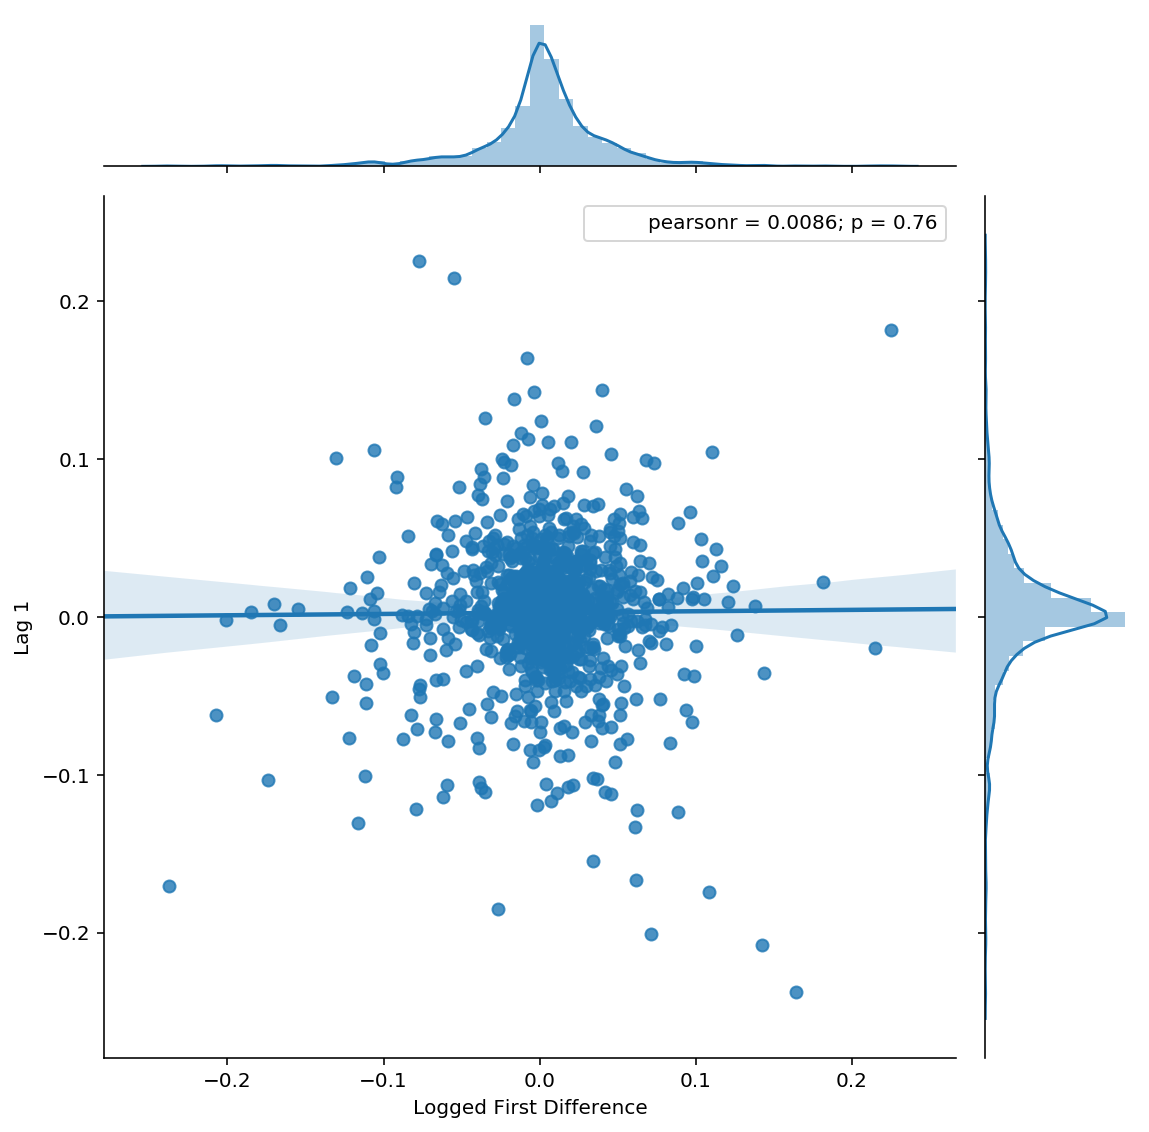

In [33]:
sns.jointplot('Logged First Difference', 'Lag 1', bdata, kind='reg', size=8)

/Users/William/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


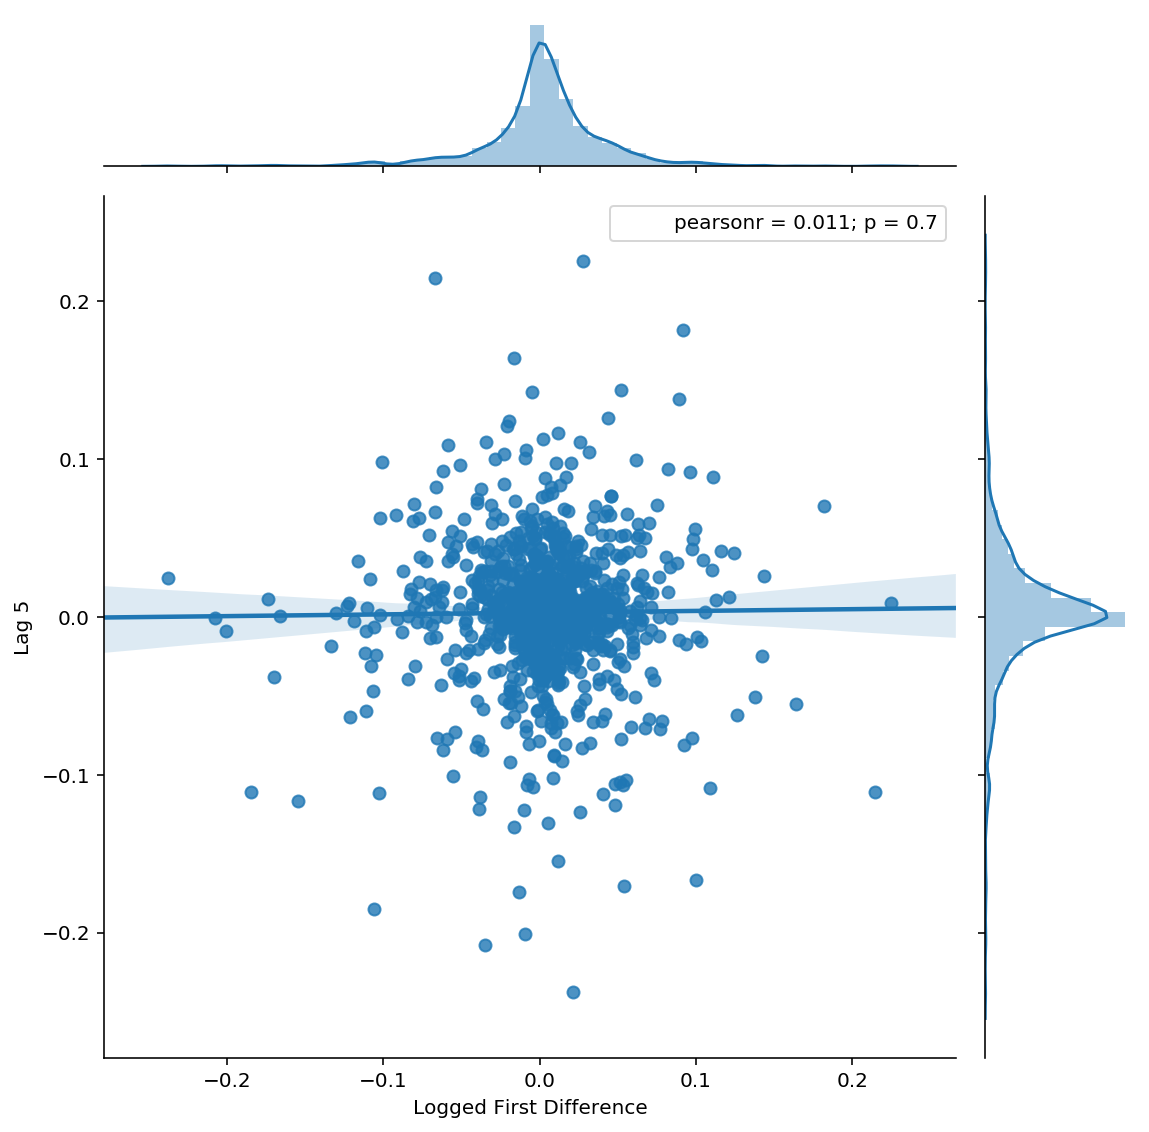

In [34]:
sns.jointplot('Logged First Difference', 'Lag 5', bdata, kind='reg', size=8)

The joint plots show zero-centered and a somewhat distribution, so therefore there is not much correlation between daily or weekly prices to the current price.

In [44]:
pd.DataFrame?

In [79]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
lag_correlations = acf(bdata['Logged First Difference'].iloc[1:])  
lag_partial_correlations = pacf(bdata['Logged First Difference'].iloc[1:])

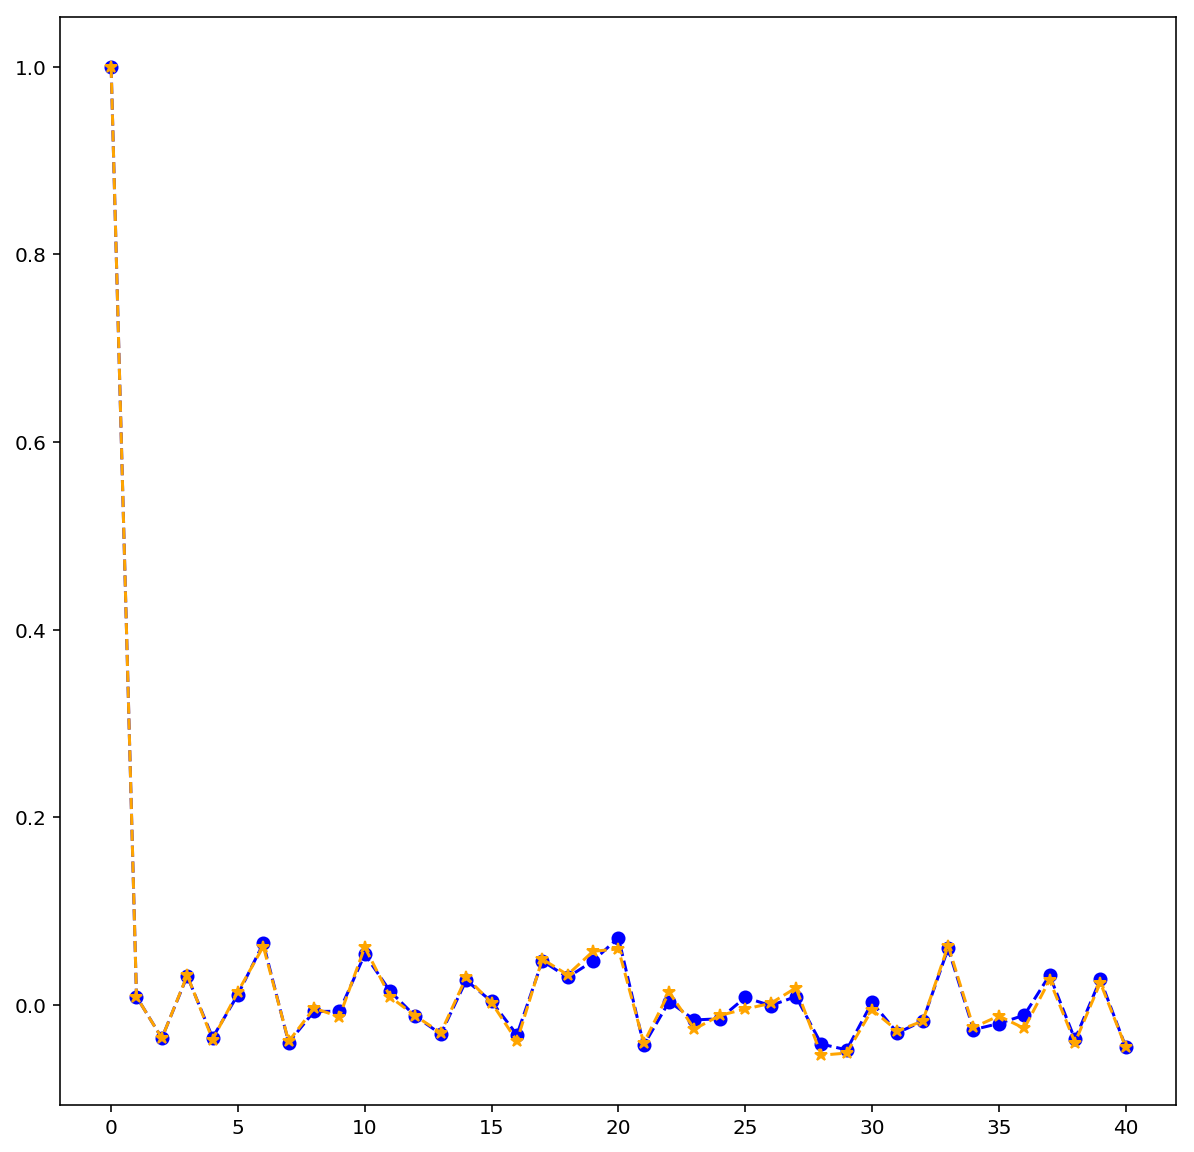

In [89]:
fig, ax = plt.subplots(figsize=(10,10))  
handles, labels = ax.get_legend_handles_labels()
ax.plot( lag_correlations, marker='o', linestyle='--', c='blue' )
ax.plot( lag_partial_correlations,  marker='*', linestyle='--', c='orange' )

Here we can see that past prices of 1 to 40 days ago do not have a very good correlation to the current price